In [51]:
# Знайти середню тривалість робочого дня для водія у суботу та неділю (window, groupby)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, min as min_, max as max_, to_date, expr, when, sum as sum_, avg, date_format, dayofweek, weekday
from pyspark.sql.window import Window
from pyspark.sql.functions import avg



In [52]:

spark = SparkSession.builder \
    .appName("SimpleApp") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")


In [53]:
# pick a driver
hack_license = df_trip.select("hack_license").groupby("hack_license").count().where("count > 10").sort("hack_license", acsending=False).first()['hack_license']

print(hack_license)


0002555BBE359440D6CEB34B699D3932


In [54]:

weekend_df = df_trip \
    .filter(col("hack_license") == hack_license) \
    .withColumn("pickup_day", weekday("pickup_datetime")) \
    .withColumn("dropoff_day", weekday("dropoff_datetime")) \
    .filter((col("pickup_day").isin(5, 6)) & (col("dropoff_day").isin(5, 6))) \
    .withColumn("trip_date", to_date("pickup_datetime")) \
    .withColumn("trip_duration_secs", unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime"))


day_window = Window.partitionBy("hack_license", "trip_date")

service_window_df = weekend_df \
    .withColumn("first_pickup", min_("pickup_datetime").over(day_window)) \
    .withColumn("last_dropoff", max_("dropoff_datetime").over(day_window)) \
    .withColumn("service_window_secs", unix_timestamp("last_dropoff") - unix_timestamp("first_pickup")) \
    .groupBy("pickup_day") \
    .agg(
        avg("service_window_secs").alias("avg_secs"),
        sum_("trip_duration_secs").alias("total_driving_secs")
    ) \
    .withColumn("driving_hours", expr("total_driving_secs / 3600")) \
    .withColumn(
        "pickup_day",
        when(col("pickup_day") == 5, "Saturday")
        .when(col("pickup_day") == 6, "Sunday")
    )


In [55]:
service_window_df.coalesce(1).write.mode("overwrite").option("header", True).csv("/Users/mac/Development/nyc-taxi-spark-project/results/2.csv")

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_plot = service_window_df.toPandas()

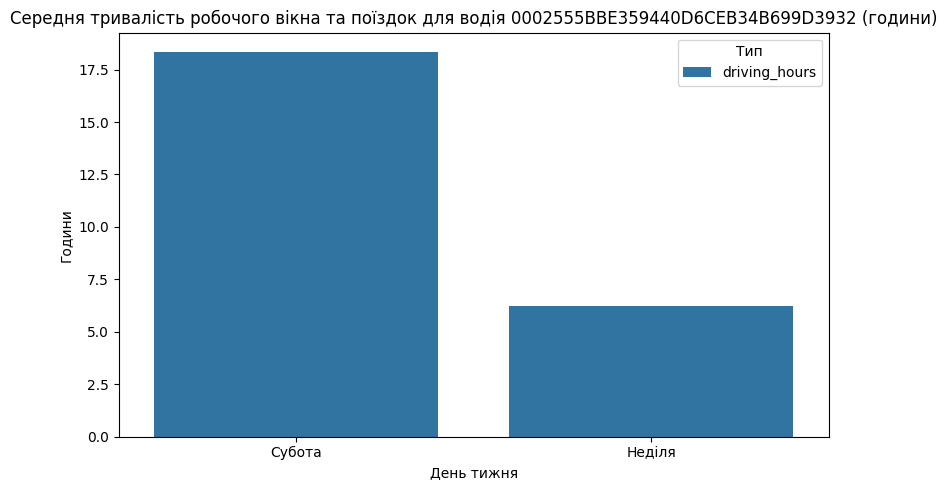

In [ ]:

df_melted = df_plot.melt(id_vars="pickup_day", value_vars=["driving_hours"],
                         var_name="type", value_name="hours")

day_map = {
    "Saturday": "Субота",
    "Sunday": "Неділя"
}
df_melted["pickup_day"] = df_melted["pickup_day"].map(day_map)
df_melted = df_melted.sort_values("pickup_day", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x="pickup_day", y="hours", hue="type")
plt.title("Середня тривалість робочого вікна та поїздок для водія 0002555BBE359440D6CEB34B699D3932 (години)")
plt.xlabel("День тижня")
plt.ylabel("Години")
plt.legend(title="Тип")
plt.tight_layout()
plt.show()